# **Music Genre Classification using Audio Dataset**

* Data link: [https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data)

* There are 10 genres with 100 audio files each, 30 seconds long in wav format

* Genres (targets)
    1) blues
    2) classical
    3) country
    4) disco
    5) hiphop
    6) jazz
    7) metal
    8) pop
    9) reggae
    10) rock

### Import neccessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# Dataset location
SOURCE_PATH = 'Dataset'

# Path to labels and processed data file, json format.
JSON_PATH = 'data.json'

# Sampling rate.
sr = 22050

# Let's make sure all files have the same amount of samples and pick a duration right under 30 seconds.
TOTAL_SAMPLES = 29 * sr

# The dataset contains 999 files. Lets make it bigger. 
# X amount of slices => X times more training examples.
NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [ ]:
def preprocess_data(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Browse each file, slice it and generate the 13 band mfcc for each slice.
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != r'Dataset\jazz\jazz.00004.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [4]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    # Load our data into numpy arrays for TensorFlow compatibility.
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [5]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [ ]:
def design_model(input_shape, targets):

    # Let's design the model architecture.
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [7]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))


In [8]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [9]:
preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)

In [10]:
inputs, targets = load_data(json_path=JSON_PATH)

In [11]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

In [ ]:
input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
model = design_model(input_shape, targets)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

In [14]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,514 (177.79 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

In [15]:
#Training the model.
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xval, yval),
                    epochs=30,
                    batch_size=32
                    )

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - acc: 0.3924 - loss: 1.7655 - val_acc: 0.4705 - val_loss: 1.4695
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.5645 - loss: 1.1929 - val_acc: 0.6411 - val_loss: 1.0108
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.6548 - loss: 0.9629 - val_acc: 0.6141 - val_loss: 1.1659
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - acc: 0.6959 - loss: 0.8649 - val_acc: 0.6762 - val_loss: 0.9478
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.7185 - loss: 0.8157 - val_acc: 0.6947 - val_loss: 0.8966
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - acc: 0.7489 - loss: 0.7064 - val_acc: 0.7232 - val_loss: 0.8137
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.7649 - loss: 0.6607 - val_acc: 0.6877 - val_loss: 0.9119
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - acc: 0.7901 - loss: 0.5974 - val_acc: 0.7357 - val_loss: 0.7972
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 33m

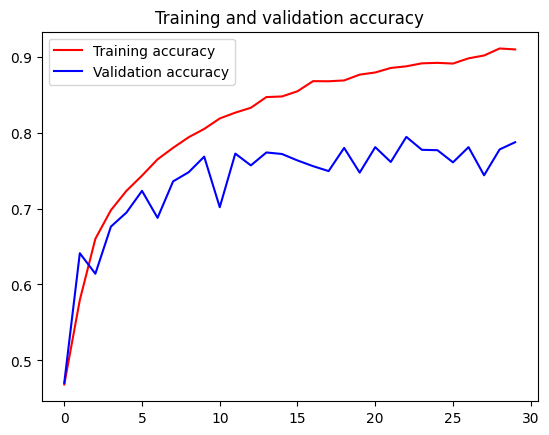

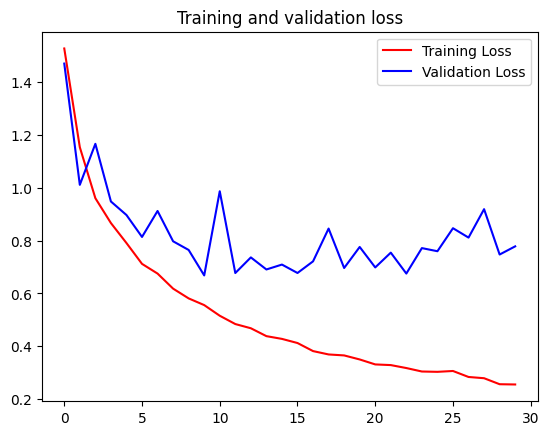

In [16]:
plot_performance(history)

In [17]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["acc"], label="train accuracy")
    axs[0].plot(hist.history["val_acc"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

Training accuracy: 0.9094321727752686
Test accuracy: 0.7872872948646545


<Figure size 2000x1500 with 0 Axes>

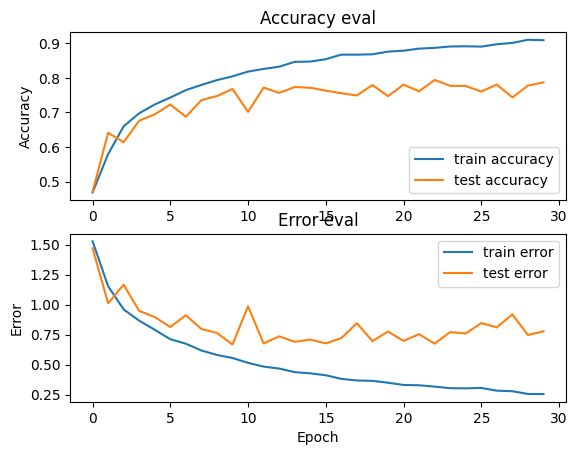

In [18]:
# Retrieve training and validation accuracy
train_accuracy = history.history['acc'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_acc'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)
plot_history(history)

In [19]:
make_prediction(model, Xtest, ytest, 24)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

---Now testing the model for one audio file---
The model predicts: classical, and ground truth is: disco.



In [20]:
import pickle

# Save the model to a file
with open('CNN.pkl', 'wb') as file:
    pickle.dump(model, file)

In [21]:
# Load the model from the file
with open('CNN.pkl', 'rb') as file_new:
    model_new = pickle.load(file_new)

In [22]:
model_new.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 4, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,838 (354.84 KB)

 Trainable params: 45,322 (177.04 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 45,324 (177.05 KB)

In [23]:
# Expected dimensions for the input
expected_height = 123
expected_width = 11

# Function to preprocess audio file
def preprocess_audio(file_path, sr=22050, duration=30, height=expected_height, width=expected_width):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    
    # Ensure audio is the expected duration
    if len(audio) < sr * duration:
        audio = np.pad(audio, (0, max(0, sr * duration - len(audio))), 'constant')
    
    # Extract features (e.g., Mel spectrogram)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=height, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Reshape for resizing
    mel_spec_db = mel_spec_db[..., np.newaxis]  # Add channel dimension
    mel_spec_db = tf.image.resize(mel_spec_db, (height, width)).numpy()
    
    # Reshape for the model input
    mel_spec_db = mel_spec_db[np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
    return mel_spec_db

In [ ]:
new_file = r'Dataset\jazz\jazz.00002.wav'
audio_data = preprocess_audio(new_file)

In [25]:
prediction = model_new.predict(audio_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [26]:
predicted_class = np.argmax(prediction, axis=1)
print(f'Predicted class: {predicted_class}')

Predicted class: [9]
